In [1]:
# import Libraries
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat
import statsmodels.api as smf
import statsmodels.formula.api as sm
from statsmodels.graphics.regressionplots import influence_plot
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from google.colab import files
uploaded = files.upload()

Saving 50_Startups.csv to 50_Startups.csv


In [3]:
data=pd.read_csv('50_Startups.csv')
data.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [4]:
data.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [6]:
df=data.copy()
df=df.rename({"R&D Spend":'RnD',"Administration":'admin',"Marketing Spend":'marketing',"State":'state',"Profit":'profit'},axis=1)
df.head()

,RnD,admin,marketing,state,profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [7]:
#Checking for missing values
df.isnull().sum()

RnD          0
admin        0
marketing    0
state        0
profit       0
dtype: int64

In [8]:
#Checking for Duplicated Values
df[df.duplicated()].shape

(0, 5)

In [9]:
#Visualizing Continuous Datatype for Outlier Detection
continuous_feature=[feature for feature in df.columns if df[feature].dtype!='O']
print('Continuous Feature Count {}'.format(len(continuous_feature)))

Continuous Feature Count 4


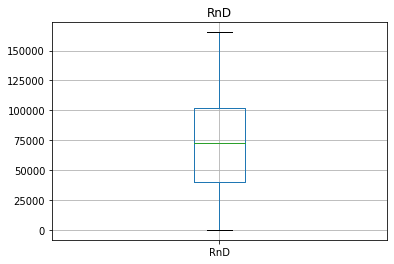

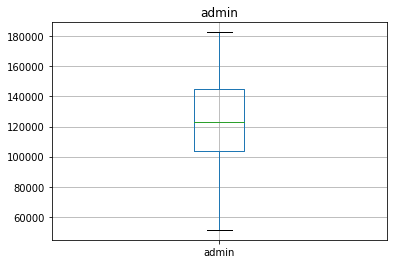

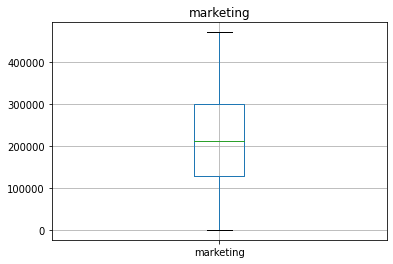

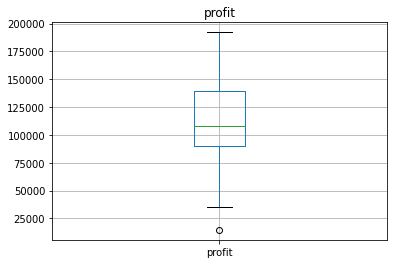

In [10]:
for feature in continuous_feature:
    data=df.copy()  
    data.boxplot(column=feature)
    plt.title(feature)
    plt.show()

In [11]:
#Let's try to find the Outliers in the Profit Dependent Variable
Q1 = np.quantile(df.profit,0.25)
Q3 = np.quantile(df.profit,0.75)
med = np.median(df.profit)
IQR = Q3 - Q1
upper_bound = Q3+(1.5*IQR)
lower_bound = Q1-(1.5*IQR)
print('First Quantile=', Q1,'\n' 'Second Quantile=', med,'\n' 'Third Quantile=', Q3,'\n'
      'Inter-Quartile Range=', IQR,'\n' 'Upper Whisker=', upper_bound,'\n' 'Lower Whisker=', lower_bound)

First Quantile= 90138.9025 
Second Quantile= 107978.19 
Third Quantile= 139765.97749999998 
Inter-Quartile Range= 49627.07499999998 
Upper Whisker= 214206.58999999997 
Lower Whisker= 15698.290000000023


In [12]:
Outliers = df.profit[(df.profit <= lower_bound) | (df.profit >= upper_bound)]
print('The outlier in the boxplot:',Outliers)

The outlier in the boxplot: 49    14681.4
Name: profit, dtype: float64


In [13]:
display(df[df.index.isin([49])],df.head())

,RnD,admin,marketing,state,profit
49,0.0,116983.8,45173.06,California,14681.4


,RnD,admin,marketing,state,profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


{'whiskers': [<matplotlib.lines.Line2D at 0x7f00b7926070>,
 'caps': [<matplotlib.lines.Line2D at 0x7f00b7912820>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f00b7926430>],
 'medians': [<matplotlib.lines.Line2D at 0x7f00b7912520>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f00b7909430>],
 'means': []}

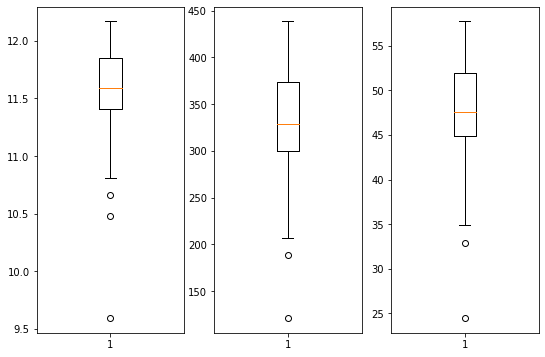

In [14]:
plt.subplots(figsize = (9,6))
plt.subplot(131)
plt.boxplot(np.log(df['profit']))
plt.subplot(132)
plt.boxplot(np.sqrt(df['profit']))
plt.subplot(133)
plt.boxplot(np.cbrt(df['profit']))

In [15]:
#Measure goodness-of-fit by finding rsquared values (percentage of variance)
raw_model = sm.ols("profit~RnD+admin+marketing", data = df).fit()
raw_model.rsquared , raw_model.rsquared_adj 

(0.9507459940683246, 0.9475337762901719)

Text(0.5, 1.0, 'Profit before median imputation')

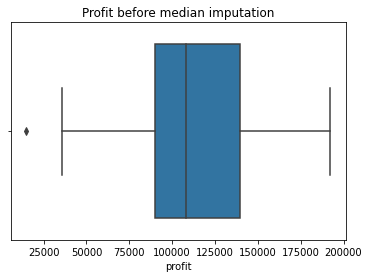

In [16]:
#Let's try Median Imputation to handle Outlier in Profit
df.profit.median()
df1=df.copy()
sns.boxplot(df['profit'])
plt.title('Profit before median imputation')

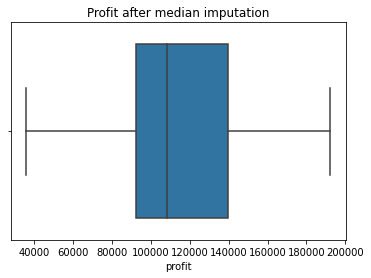

In [17]:
for i in df1['profit']:
    q1 = np.quantile(df.profit,0.25)
    q3 = np.quantile(df.profit,0.75)
    med = np.median(df.profit)
    iqr = q3 - q1
    upper_bound = q3+(1.5*iqr)
    lower_bound = q1-(1.5*iqr)
    if i > upper_bound or i < lower_bound:
        df1['profit'] = df1['profit'].replace(i, np.median(df1['profit']))
sns.boxplot(df1['profit'])
plt.title('Profit after median imputation')
plt.show()

In [18]:
#Let's test our data in model and compare the R-squared with Median imputation data model
after_median_imputation_model = sm.ols("profit~RnD+admin+marketing", data = df1).fit()
after_median_imputation_model.rsquared , after_median_imputation_model.rsquared_adj 

(0.9182958360807372, 0.91296730365122)

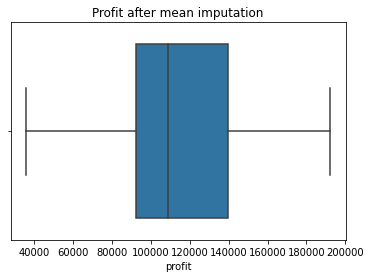

In [19]:
#Let's try Mean Imputation to handle Outlier in Profit
df2=df.copy()
for i in df2['profit']:
    q1 = np.quantile(df2.profit,0.25)
    q3 = np.quantile(df2.profit,0.75)
    med = np.median(df2.profit)
    iqr = q3 - q1
    upper_bound = q3+(1.5*iqr)
    lower_bound = q1-(1.5*iqr)
    if i > upper_bound or i < lower_bound:
        df2['profit'] = df2['profit'].replace(i, np.mean(df2['profit']))
sns.boxplot(df2['profit'])
plt.title('Profit after mean imputation')
plt.show()

In [20]:
#Let's test our data in model and compare the R-squared with Mean imputation data model
after_mean_imputation_model = sm.ols("profit~RnD+admin+marketing", data = df2).fit()
# Finding rsquared values
after_mean_imputation_model.rsquared , after_mean_imputation_model.rsquared_adj 

(0.9119537155310937, 0.9062115665439912)

In [21]:
#The best thing we can do is now to remove the outlier and see the results
df3=df.copy()
def drop_outliers(data, field_name):
    iqr = 1.5*(np.percentile(data[field_name], 75) - np.percentile(data[field_name], 25))
    data.drop(data[data[field_name] > (iqr + np.percentile(data[field_name], 75))].index, inplace=True)
    data.drop(data[data[field_name] < (np.percentile(data[field_name], 25) - iqr)].index, inplace=True)


Text(0.5, 1.0, 'Profit after removing outliers')

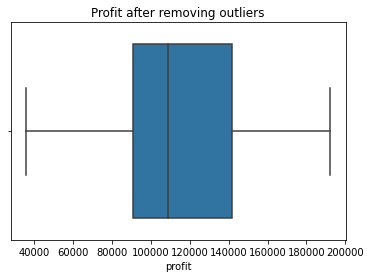

In [22]:
drop_outliers(df3, 'profit')
sns.boxplot(df3.profit)
plt.title('Profit after removing outliers')

In [23]:
#Let's test our data in model and compare the R-squared with and without imputation data models
removed_outlier_model = sm.ols("profit~RnD+admin+marketing", data = df3).fit()
# Finding rsquared values
removed_outlier_model.rsquared , removed_outlier_model.rsquared_adj

(0.9613162435129848, 0.9587373264138505)

In [24]:
from scipy.stats import shapiro

#perform Shapiro-Wilk test
print('R&D Spend feature',shapiro(df3.RnD),'\n'
     'Administration feature',shapiro(df3.admin),'\n'
     'Marketing Spend feature',shapiro(df3.marketing),'\n'
     'Profit feature',shapiro(df3.profit))

R&D Spend feature ShapiroResult(statistic=0.9705318212509155, pvalue=0.2542237639427185) 
Administration feature ShapiroResult(statistic=0.9695432186126709, pvalue=0.23222382366657257) 
Marketing Spend feature ShapiroResult(statistic=0.9757168889045715, pvalue=0.401671826839447) 
Profit feature ShapiroResult(statistic=0.9793398380279541, pvalue=0.537902295589447)


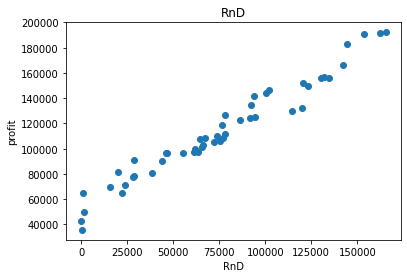

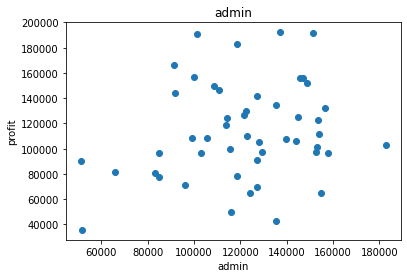

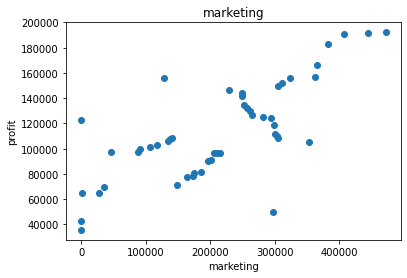

In [25]:
#Visualizing the Relation between each independent Feature with respect to the Dependent Feature
for feature in continuous_feature:
    if feature!="profit":
        data=df3.copy()         
        plt.scatter(data[feature],data['profit'])
        plt.xlabel(feature)
        plt.ylabel('profit')
        plt.title(feature)
        plt.show()

In [27]:
#We are going to drop 'state' feature while building model as it is an irrelevant feature for our inferences
df4=df3.drop('state',axis=1)
df4.head()

,RnD,admin,marketing,profit
0,165349.20,136897.80,471784.10,192261.83
1,162597.70,151377.59,443898.53,191792.06
2,153441.51,101145.55,407934.54,191050.39
3,144372.41,118671.85,383199.62,182901.99
4,142107.34,91391.77,366168.42,166187.94


In [29]:
#Checking the correlation between Variables
df4.corr()

,RnD,admin,marketing,profit
RnD,1.000000,0.243438,0.711654,0.978437
admin,0.243438,1.000000,-0.037280,0.205841
marketing,0.711654,-0.037280,1.000000,0.739307
profit,0.978437,0.205841,0.739307,1.000000


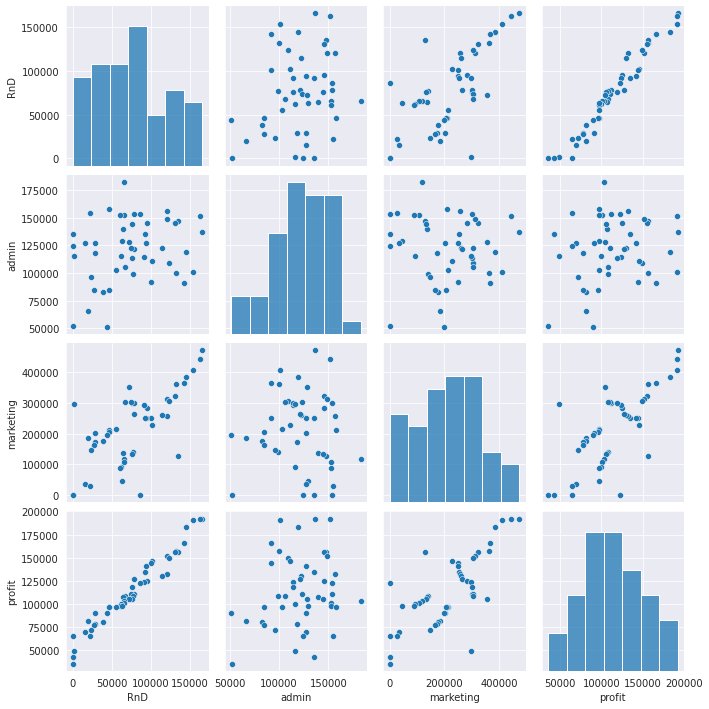

In [30]:
#Plotting Correlation on a Pair Plot
sns.set_style(style='darkgrid')
sns.pairplot(df4)

In [31]:
#Applying Standard Scaler
df_standard_scaled = df4.copy()
features = df_standard_scaled[continuous_feature]

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_standard_scaled[continuous_feature] = scaler.fit_transform(features.values)
df_standard_scaled.head()

,RnD,admin,marketing,profit
0,2.018325,0.552080,2.146120,2.071556
1,1.956704,1.069017,1.913596,2.059122
2,1.751650,-0.724297,1.613709,2.039490
3,1.548545,-0.098597,1.407457,1.823808
4,1.497818,-1.072513,1.265442,1.381401


In [33]:
#Now if we check the mean and standard deviation of our scaled data it should have a Mean '0' and Standard deviation '1'
print('Mean' '\n',np.round(df_standard_scaled.mean(),1),'\n' 'Standard Devaition','\n',np.round(df_standard_scaled.std()),1)

Mean
 RnD          0.0
admin       -0.0
marketing   -0.0
profit      -0.0
dtype: float64 
Standard Devaition 
 RnD          1.0
admin        1.0
marketing    1.0
profit       1.0
dtype: float64 1


In [34]:
#Preparing a Model
import statsmodels.formula.api as sm
model = sm.ols("profit~RnD+admin+marketing", data = df_standard_scaled).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     372.8
Date:                Mon, 12 Dec 2022   Prob (F-statistic):           8.85e-32
Time:                        06:48:36   Log-Likelihood:                 10.154
No. Observations:                  49   AIC:                            -12.31
Df Residuals:                      45   BIC:                            -4.741
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.388e-16      0.029  -4.73e-15      1.000      -0.059       0.059
RnD            0.9254      0.045     20.470      0.000       0.834       1.017
admin         -0.0165      0.032     -0.518      0.607      -0.080       0.048
marketing      0.0801      0.044      1.825      0.075      -0.008       0.168
==============================================================================
Omnibus:                        0.082   Durbin-Watson:                   1.598
Prob(Omnibus):                  0.960   Jarque-Bera (JB):                0.232
Skew:                          -0.082   Prob(JB):                        0.890
Kurtosis:                       2.706   Cond. No.                         2.72
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
# Finding Coefficient parameters
model.params

Intercept   -1.387779e-16
RnD          9.254411e-01
admin       -1.646059e-02
marketing    8.009988e-02
dtype: float64

In [36]:
# Finding tvalues and pvalues
display(model.tvalues, model.pvalues)

Intercept   -4.733280e-15
RnD          2.046950e+01
admin       -5.178888e-01
marketing    1.825383e+00
dtype: float64

Intercept    1.000000e+00
RnD          1.971077e-24
admin        6.070728e-01
marketing    7.458443e-02
dtype: float64

In [37]:
#Simple Linear Regression to separately check the dependency between those feature with Target feature
admin_slr_model = sm.ols("profit~admin", data = df_standard_scaled).fit()
display(admin_slr_model.tvalues, admin_slr_model.pvalues)

Intercept   -1.458350e-15
admin        1.442053e+00
dtype: float64

Intercept    1.000000
admin        0.155918
dtype: float64

In [38]:
# Finding rsquared values
admin_slr_model.rsquared , admin_slr_model.rsquared_adj 

(0.04237035844418102, 0.02199525968767435)

In [39]:
marketing_slr_model = sm.ols("profit~marketing", data = df_standard_scaled).fit()
display(marketing_slr_model.tvalues, marketing_slr_model.pvalues)

Intercept   -2.119374e-15
marketing    7.526983e+00
dtype: float64

Intercept    1.000000e+00
marketing    1.304853e-09
dtype: float64

In [40]:
# Finding rsquared values
marketing_slr_model.rsquared , marketing_slr_model.rsquared_adj 

(0.5465748398585546, 0.536927496025758)

In [41]:
# So if we combine admin and marketing feature to predict profit we should get a total R-sqaure value of 58%.
admin_plus_marketing= sm.ols('profit~admin+marketing', data =df_standard_scaled).fit()
admin_plus_marketing.rsquared , admin_plus_marketing.rsquared_adj 

(0.6011271008483878, 0.5837848008852743)

In [42]:
# Method to calculate VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
x = df_standard_scaled[['marketing','admin','RnD']]
vif_data = pd.DataFrame()
vif_data['Features'] = x.columns
vif_data['VIF'] = [vif(x.values, i) for i in range(len(x.columns))]
vif_data.sort_values(by = ['VIF'])

,Features,VIF
1,admin,1.175172
0,marketing,2.239957
2,RnD,2.377754


None of the variables has VIF>20, No Collinearity, but we cannot consider all varaibles in Regression equation

In [43]:
#Let's build two model in each model one of the feature will not be present
admin_present_model= sm.ols('profit~RnD+admin', data= df4).fit()
admin_present_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     530.6
Date:                Mon, 12 Dec 2022   Prob (F-statistic):           1.69e-32
Time:                        06:49:11   Log-Likelihood:                -508.03
No. Observations:                  49   AIC:                             1022.
Df Residuals:                      46   BIC:                             1028.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.682e+04   5105.017     11.131      0.000    4.65e+04    6.71e+04
RnD            0.8349      0.026     31.847      0.000       0.782       0.888
admin         -0.0464      0.042     -1.110      0.273      -0.131       0.038
==============================================================================
Omnibus:                        0.444   Durbin-Watson:                   1.498
Prob(Omnibus):                  0.801   Jarque-Bera (JB):                0.245
Skew:                          -0.173   Prob(JB):                        0.885
Kurtosis:                       2.972   Cond. No.                     6.64e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
marketing_present_model= sm.ols('profit~RnD+marketing', data= df4).fit()
marketing_present_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     568.0
Date:                Mon, 12 Dec 2022   Prob (F-statistic):           3.74e-33
Time:                        06:49:18   Log-Likelihood:                -506.43
No. Observations:                  49   AIC:                             1019.
Df Residuals:                      46   BIC:                             1025.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.979e+04   2341.584     21.261      0.000    4.51e+04    5.45e+04
RnD            0.7754      0.035     22.136      0.000       0.705       0.846
marketing      0.0274      0.013      2.104      0.041       0.001       0.054
==============================================================================
Omnibus:                        0.082   Durbin-Watson:                   1.546
Prob(Omnibus):                  0.960   Jarque-Bera (JB):                0.273
Skew:                          -0.051   Prob(JB):                        0.872
Kurtosis:                       2.649   Cond. No.                     5.52e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
#Comparing different models with respect to their Root Mean Squared Errors
print('Adminstration Model=', np.sqrt(admin_present_model.mse_resid),'\n''Marketing Model=', np.sqrt(marketing_present_model.mse_resid))

Adminstration Model= 7947.922013017301 
Marketing Model= 7691.884748549171


In [46]:
#We are going to rebuild the model by dropping the Administration feature
final_model = sm.ols('profit~RnD+marketing', data=df4).fit()
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     568.0
Date:                Mon, 12 Dec 2022   Prob (F-statistic):           3.74e-33
Time:                        06:49:27   Log-Likelihood:                -506.43
No. Observations:                  49   AIC:                             1019.
Df Residuals:                      46   BIC:                             1025.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.979e+04   2341.584     21.261      0.000    4.51e+04    5.45e+04
RnD            0.7754      0.035     22.136      0.000       0.705       0.846
marketing      0.0274      0.013      2.104      0.041       0.001       0.054
==============================================================================
Omnibus:                        0.082   Durbin-Watson:                   1.546
Prob(Omnibus):                  0.960   Jarque-Bera (JB):                0.273
Skew:                          -0.051   Prob(JB):                        0.872
Kurtosis:                       2.649   Cond. No.                     5.52e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

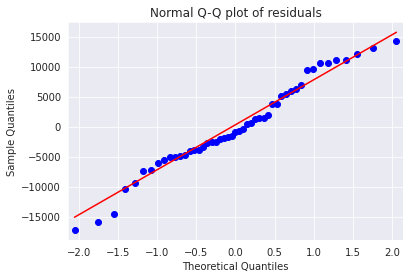

In [47]:
#Residuals values  = y - yhat
smf.qqplot(final_model.resid, line = 'q')
plt.title('Normal Q-Q plot of residuals')
plt.show()

In [48]:
#Residual Plot for Homoscedasticity
def get_standardized_values( vals ):
    return (vals - vals.mean())/vals.std()

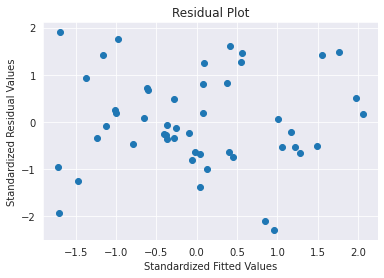

In [49]:
plt.scatter(get_standardized_values(final_model.fittedvalues), get_standardized_values(final_model.resid))
plt.title('Residual Plot')
plt.xlabel('Standardized Fitted Values')
plt.ylabel('Standardized Residual Values')
plt.show()

In [50]:
#Detecting Influencers/Outliers in the Model by using Cook's Distance
influence_points=final_model.get_influence()
c, p_value=influence_points.cooks_distance

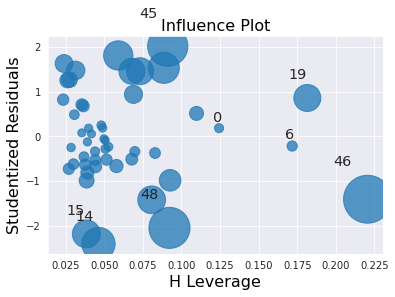

In [51]:
# Leverage Value using High Influence Points : Points beyond Leverage_cutoff value are influencers
influence_plot(final_model)
plt.show()

In [52]:
k=df4.shape[1]
n=df4.shape[0]
leverage_cutoff = (3*(k+1))/n
print('Cut-off line at',np.round(leverage_cutoff,2))

Cut-off line at 0.31


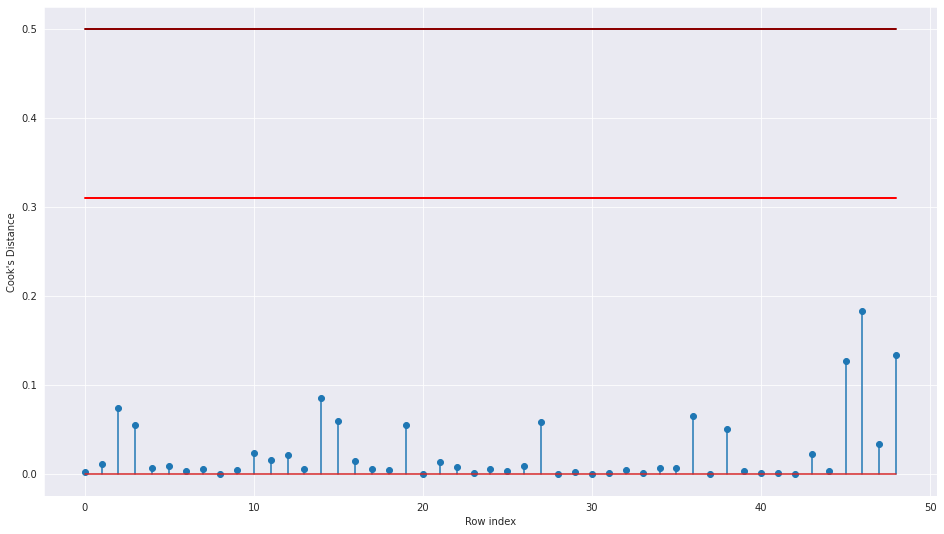

In [53]:
#Let's plot the influencers and also plot a cut off line using the stem plot
fig = plt.figure(figsize = (16,9))
x = [0,48]
y = [0.5,0.5]
plt.plot(x, y,color='darkred', linewidth=2)
y1 = [0.31,0.31]
plt.plot(x , y1, color = 'red', linewidth = 2)
plt.stem(np.arange(len(df4)), np.round(c, 3))
plt.xlabel('Row index')
plt.ylabel("Cook's Distance")
plt.show()

In [54]:
#Predicting values from Model using same dataset
predicted = pd.DataFrame()
predicted['RnD'] = df4.RnD
predicted['marketing'] = df4.marketing
predicted['Profit'] = df4.profit
predicted['Predicted_Profit'] = pd.DataFrame(final_model.predict(predicted[['RnD','marketing']]))
predicted

,RnD,marketing,Profit,Predicted_Profit
0,165349.20,471784.10,192261.83,190942.726927
1,162597.70,443898.53,191792.06,188043.924520
2,153441.51,407934.54,191050.39,179957.312472
3,144372.41,383199.62,182901.99,172246.416164
4,142107.34,366168.42,166187.94,170022.687457
5,131876.90,362861.36,156991.12,161999.405410
6,134615.46,127716.82,156122.51,157669.178690
7,130298.13,323876.68,155752.60,159705.298181
8,120542.52,311613.29,152211.77,151804.380605
9,123334.88,304981.62,149759.96,153787.521922


In [55]:
# say New data for prediction is
new_data=pd.DataFrame({'RnD':0.0,"marketing":45173.06},index=[0])
new_data

,RnD,marketing
0,0.0,45173.06


In [56]:
new_data['predited_profit']=final_model.predict(new_data)
new_data

,RnD,marketing,predited_profit
0,0.0,45173.06,51025.067542


In [57]:
#Table containing R^2 value for each prepared model
models={'Different_Models':['Raw_data','Median_Imputation_Outlier','Mean_Imputation_outlier','Removed_outlier','Final_Model'],
        'R_squared':[raw_model.rsquared,after_median_imputation_model.rsquared,after_mean_imputation_model.rsquared,removed_outlier_model.rsquared,final_model.rsquared],
        'R_squared_adjusted':[raw_model.rsquared_adj,after_median_imputation_model.rsquared_adj,after_mean_imputation_model.rsquared_adj,removed_outlier_model.rsquared_adj,final_model.rsquared_adj],
       'RMSE':[np.sqrt(raw_model.mse_resid),np.sqrt(after_median_imputation_model.mse_resid),np.sqrt(after_mean_imputation_model.mse_resid),np.sqrt(removed_outlier_model.mse_resid),np.sqrt(final_model.mse_resid)]}
model_table=pd.DataFrame(models)
model_table

,Different_Models,R_squared,R_squared_adjusted,RMSE
0,Raw_data,0.950746,0.947534,9232.334837
1,Median_Imputation_Outlier,0.918296,0.912967,11148.345424
2,Mean_Imputation_outlier,0.911954,0.906212,11570.325358
3,Removed_outlier,0.961316,0.958737,7753.807752
4,Final_Model,0.961086,0.959394,7691.884749
